# Анализ эксперимента с предложением на экране оплаты

## Описание эксперимента

Вариант A: экран оплаты без рекламного предложения "Вам это пригодится".</br>
Вариант B: экран оплаты с рекламным предложением "Вам это пригодится"

**Цель эксперимента:**</br>
Увеличение выручки.

## Данные

Файлы с заказами (orders.csv) и посетителями по дням и группам (visitors.csv).

Файл `orders.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/orders.csv)

- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

Файл `visitors.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/visitors.csv)

- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

## Результаты и рекомендации

В целом тест оказался удачным, так как действительно привёл к росту общего Revenue за счёт повышения конверсии.</br>
С другой стороны, предложение не повысило стоимость заказов, хотя по идее рекламные предложения уже на этапе покупки должны повысить именно средний чек.</br>

Предполагаю, что такое могло произойти при наличии минимальной суммы заказа или порога для бесплатной доставки. Люди, изначально не достигающие такого порога, благодаря рекомендациям смогли пополнить корзину по необходимого минимума, что и вызвало рост конверсии.

**Общая сводка по группам:**

In [27]:
stats_total

,group,visitors,customers,orders,revenue,aov,mov,arpu,arppu,cr,orders_per_customer
0,A,18736,503,557,4084803,7333.578,3000.0,218.019,8120.881,0.030,1.107
1,B,18916,586,640,5907760,9230.875,2965.0,312.316,10081.502,0.034,1.092


**Результаты:**</br>
1. Конверсия в оплату значимо выше в группе B. Прирост составил 13,3% или 0.4 п.п. Доверительные интервалы: 3.12% — 3.64%.
2. По AOV и ARPPU значимой разницы между группами нет.
3. Предположительный прирост выручки из-за роста конверсии может составить от 5% до 22%.

**Рекомендации:**</br>
1. Раскатить тест на 100% пользователей, так как изменения положительно влияют на конверсию.
2. Провести дополнительные исследования по взаимодействию клиентов с рекламными предложениями. Нужно выяснить, почему выросла именно конверсия, а средний чек остался прежним.
3. После исследований оптимизировать алгоритм рекомендаций и повторить эксперимент.
4. Исследовать корзины пользователей c visitorId 1920142716, 2108080724 и проинтервьюировать их. Возможно, есть новый премиум или b2b сегмент.

## Анализ

### Библиотеки и основные функции

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option("display.precision", 3)

In [3]:
#Сравнение двух выборок: проверка гипотезы о том, что разница между двумя бутстрап распределениями равна 0

def bootstrap(a, b, iter_count=1000):
    boot_list = []
    boot_list1 = []
    boot_list2 = []
    
    n=max(len(a),len(b))
    
    for i in range(iter_count):
        s1 = pd.DataFrame(a).sample(n, replace=True)
        s2 = pd.DataFrame(b).sample(n, replace=True)
        mean_s1 = float(s1.mean())
        mean_s2 = float(s2.mean())
        boot_list1 = np.append(boot_list1,mean_s1)
        boot_list2 = np.append(boot_list2,mean_s2)
        mean_dif = mean_s1-mean_s2
        boot_list = np.append(boot_list,mean_dif)
        
    m = np.mean(boot_list)
    std = np.std(boot_list)
    m1 = np.mean(boot_list1)
    std1 = np.std(boot_list1)
    m2 = np.mean(boot_list2)
    std2 = np.std(boot_list2)
    
    p1 = stats.norm.sf(0, loc=m, scale=std)
    p2 = stats.norm.sf(0, loc=-m, scale=std)
    
    p = min(p1, p2) * 2

    return {'m':m, 'std':std, 'm1':m1, 'm2':m2, 'std1': std1, 'std2': std2, 'Kv1':std1/m1, 'Kv2':std2/m2, 'pvalue':p}, sns.distplot(boot_list1),sns.distplot(boot_list2);

### Data Loading and Processing

In [4]:
orders = pd.read_csv('orders.csv')
visitors = pd.read_csv('visitors.csv')

In [5]:
orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [6]:
visitors

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


Соберём из этого датасорсы тотал и по дням. Они пригодятся для более детального анализа эксперимента.

In [7]:
orders_by_day = orders \
    .groupby(['group', 'date']) \
    .agg(
        customers = ('visitorId', pd.Series.nunique),
        orders = ('transactionId', pd.Series.count),
        revenue = ('revenue', pd.Series.sum),
        aov = ('revenue', pd.Series.mean),
        mov = ('revenue', pd.Series.median)
    ) \
    .reset_index()

stats_by_day = pd.merge(
    left=visitors,
    right=orders_by_day,
    on=['date', 'group']
)

stats_by_day['arpu'] = stats_by_day['revenue'] / stats_by_day['visitors']
stats_by_day['arppu'] = stats_by_day['revenue'] / stats_by_day['customers']
stats_by_day['cr'] = stats_by_day['orders'] / stats_by_day['visitors']
stats_by_day['orders_per_customer'] = stats_by_day['orders'] / stats_by_day['customers']

stats_by_day['visitors_cum'] = stats_by_day.groupby('group')['visitors'].cumsum()
stats_by_day['customers_cum'] = stats_by_day.groupby('group')['customers'].cumsum()
stats_by_day['orders_cum'] = stats_by_day.groupby('group')['orders'].cumsum()
stats_by_day['revenue_cum'] = stats_by_day.groupby('group')['revenue'].cumsum()

In [8]:
stats_by_day

,date,group,visitors,customers,orders,revenue,aov,mov,arpu,arppu,cr,orders_per_customer,visitors_cum,customers_cum,orders_cum,revenue_cum
0,2019-08-01,A,719,20,24,148579,6190.792,3167.5,206.647,7428.950,0.033,1.200,719,20,24,148579
1,2019-08-02,A,619,19,20,93822,4691.100,2430.0,151.570,4938.000,0.032,1.053,1338,39,44,242401
2,2019-08-03,A,507,24,24,112473,4686.375,3489.0,221.840,4686.375,0.047,1.000,1845,63,68,354874
3,2019-08-04,A,717,15,16,70825,4426.562,2285.0,98.780,4721.667,0.022,1.067,2562,78,84,425699
4,2019-08-05,A,756,25,25,124218,4968.720,1990.0,164.310,4968.720,0.033,1.000,3318,103,109,549917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,2019-08-27,B,720,16,16,147677,9229.812,860.0,205.107,9229.812,0.022,1.000,16523,537,548,5232260
58,2019-08-28,B,654,27,28,96008,3428.857,1874.0,146.801,3555.852,0.043,1.037,17177,564,576,5328268
59,2019-08-29,B,531,20,20,231130,11556.500,4413.5,435.273,11556.500,0.038,1.000,17708,584,596,5559398
60,2019-08-30,B,490,24,24,215233,8968.042,2990.0,439.251,8968.042,0.049,1.000,18198,608,620,5774631


In [9]:
orders_total = orders \
    .groupby(['group']) \
    .agg(
        customers = ('visitorId', pd.Series.nunique),
        orders = ('transactionId', pd.Series.count),
        revenue = ('revenue', pd.Series.sum),
        aov = ('revenue', pd.Series.mean),
        mov = ('revenue', pd.Series.median)
    ) \
    .reset_index()

visitors_total = visitors \
    .groupby(['group']) \
    .agg(
        visitors = ('visitors', pd.Series.sum)
    ) \
    .reset_index()

stats_total = pd.merge(
    left=visitors_total,
    right=orders_total,
    on='group'
)

stats_total['arpu'] = stats_total['revenue'] / stats_total['visitors']
stats_total['arppu'] = stats_total['revenue'] / stats_total['customers']
stats_total['cr'] = stats_total['orders'] / stats_total['visitors']
stats_total['orders_per_customer'] = stats_total['orders'] / stats_total['customers']

In [10]:
stats_total

,group,visitors,customers,orders,revenue,aov,mov,arpu,arppu,cr,orders_per_customer
0,A,18736,503,557,4084803,7333.578,3000.0,218.019,8120.881,0.030,1.107
1,B,18916,586,640,5907760,9230.875,2965.0,312.316,10081.502,0.034,1.092


### Test analysis

#### CR

Для оценки различий между группами воспользуемся критерием Хи-квадрат Пирсона и рассчитаем доверительные интервалы:

In [11]:
cr_data = stats_total[['group','visitors', 'orders', 'cr']]

stat, p, dof, expected = stats.chi2_contingency(cr_data[['visitors', 'orders']].values)


cr_a = cr_data[cr_data['group'] == 'A']['cr'].values[0]
cr_b = cr_data[cr_data['group'] == 'B']['cr'].values[0]
visitors_a = cr_data[cr_data['group'] == 'A']['visitors'].values[0]
visitors_b = cr_data[cr_data['group'] == 'B']['visitors'].values[0]

ci_high_a = cr_a + (1.96 * (cr_a * ((1 - cr_a) / visitors_a))**0.5)
ci_low_a = cr_a - (1.96 * (cr_a * ((1 - cr_a)**0.5 / visitors_a))**0.5)

ci_high_b = cr_b + (1.96 * (cr_b * ((1 - cr_b)**0.5 / visitors_b))**0.5)
ci_low_b = cr_b - (1.96 * (cr_b * ((1 - cr_b)**0.5 / visitors_b))**0.5)


print(f'Значение p-value: {round(p, 3)}')
print(f'Доверительный интервал для группы A: {round(ci_low_a * 100, 2)}% — {round(ci_high_a * 100, 2)}%')
print(f'Доверительный интервал для группы B: {round(ci_low_b * 100, 2)}% — {round(ci_high_b * 100, 2)}%')

Значение p-value: 0.03
Доверительный интервал для группы A: 2.73% — 3.22%
Доверительный интервал для группы B: 3.12% — 3.64%


Так как p-value < 0.05, результат можно считать значимым.
</br>
Похоже, что в тестовой группе B конверсия в покупку действительно больше. Но посмотрим на динамику p-value по дням:

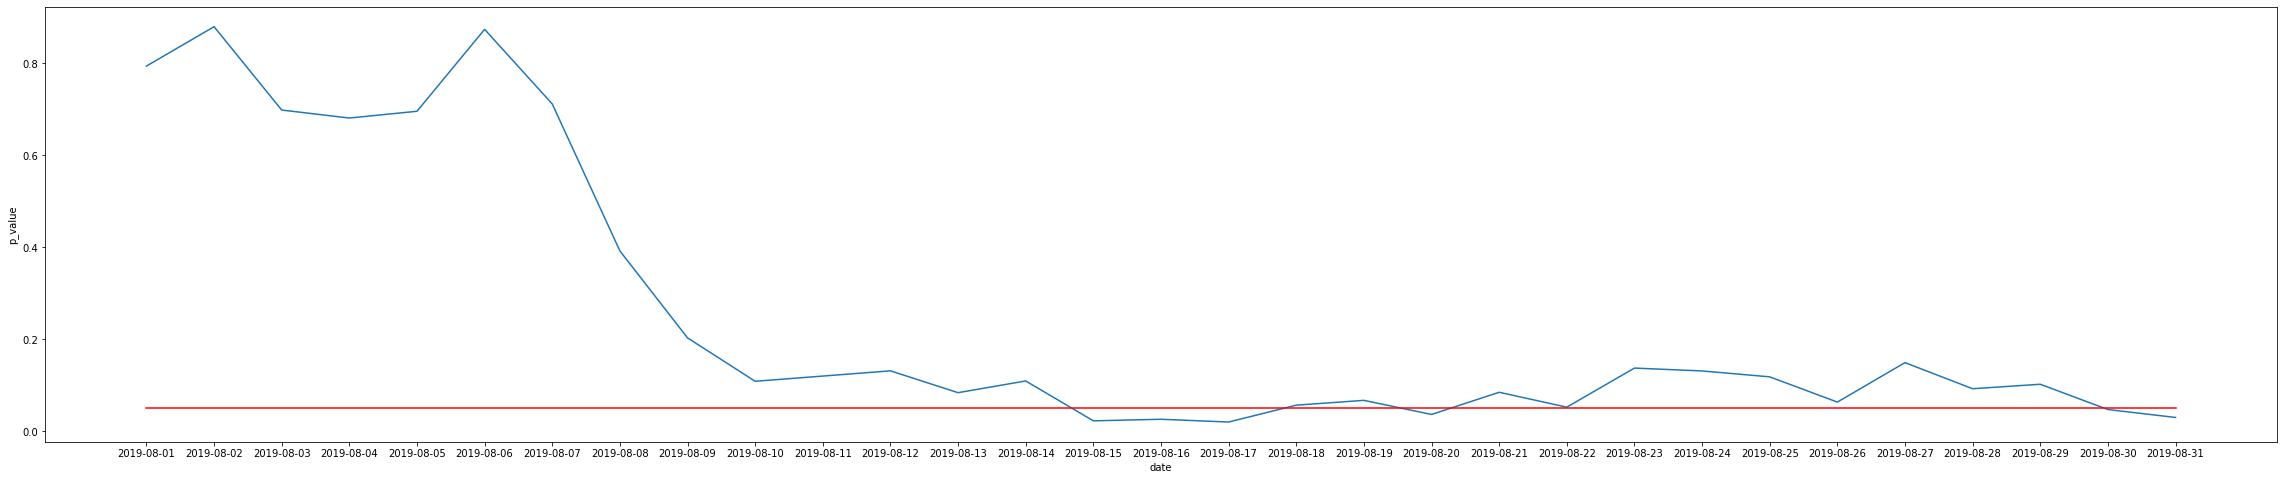

In [12]:
cr_by_day = pd.DataFrame(columns=['date', 'p_value'])

for date in sorted(stats_by_day['date'].unique()):
    p_value = stats.chi2_contingency(stats_by_day[stats_by_day['date'] == date][['visitors_cum', 'orders_cum']].values)[1]
    
    cr_by_day = pd.concat([cr_by_day, pd.DataFrame([[date, p_value]], columns=cr_by_day.columns)], ignore_index=True)
    

plt.figure(figsize=(40,8))
sns.lineplot(data=cr_by_day, x='date', y='p_value')
sns.lineplot(data=cr_by_day, x='date', y=0.05, color='r')
plt.show();

**Вывод:**

Конверсия в заказ стат. значимо выше в тестовой группе B на 15% (0.4 п.п).

#### AOV

Прежде всего, посмотрим, на распределение квантилей AOV по группам:

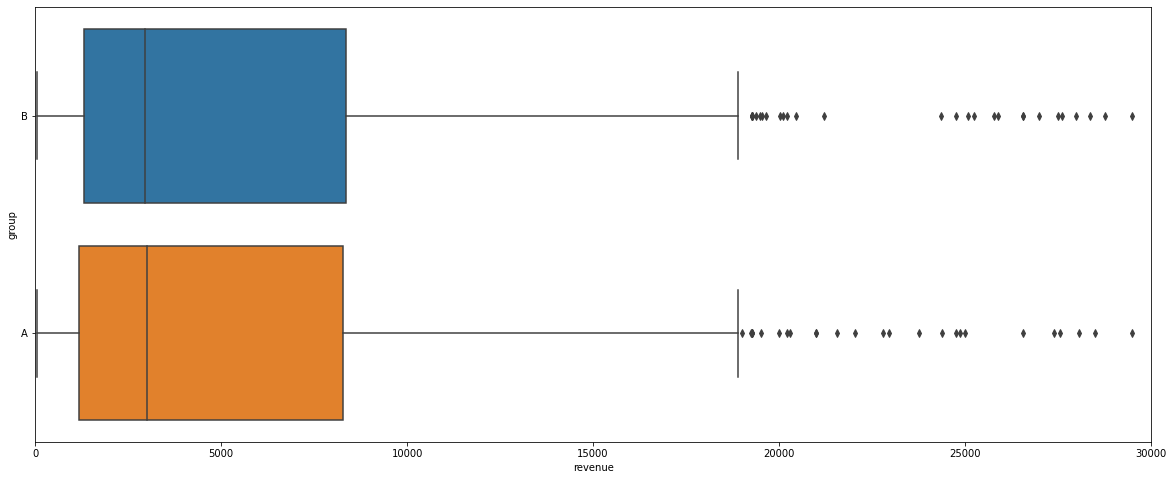

In [13]:
plt.figure(figsize=(20,8))
ax = sns.boxplot(data=orders, x='revenue', y='group')

ax.set(xlim=(0, 30000));

На глаз разницы практически нет. Посмотрим на распределение плотности вероятности:

<Figure size 1440x576 with 0 Axes>

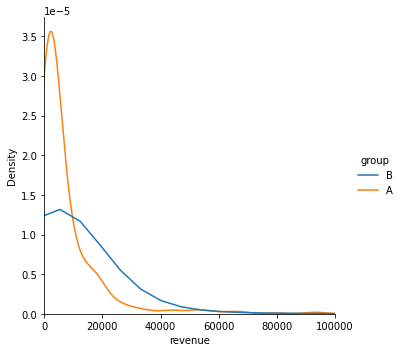

In [14]:
plt.figure(figsize=(20,8))
ax = sns.displot(data=orders, x="revenue", hue="group", kind="kde")

ax.set(xlim=(0, 100000));

Тут уже интереснее — у группы B плотность вероятности перераспределяется в сторону большего чека.

Попробуем убрать выбросы и посчитать значимость различий. Убирать выбросы буду с помощью межквартильного расстояния:

In [15]:
orders_a = orders[(orders['group'] == 'A')].copy()
a_high_ci = orders_a['revenue'].quantile(.75) + 1.5 * (orders_a['revenue'].quantile(.75) - orders_a['revenue'].quantile(.25))
a_low_ci = orders_a['revenue'].quantile(.75) - 1.5 * (orders_a['revenue'].quantile(.75) - orders_a['revenue'].quantile(.25))
orders_a = orders_a[(orders_a['revenue'] <= a_high_ci) & (orders_a['revenue'] >= a_low_ci)]

orders_b = orders[(orders['group'] == 'B')].copy()
b_high_ci = orders_b['revenue'].quantile(.75) + 1.5 * (orders_b['revenue'].quantile(.75) - orders_b['revenue'].quantile(.25))
b_low_ci = orders_b['revenue'].quantile(.75) - 1.5 * (orders_b['revenue'].quantile(.75) - orders_b['revenue'].quantile(.25))
orders_b = orders_b[(orders_b['revenue'] <= b_high_ci) & (orders_b['revenue'] >= b_low_ci)]

<Figure size 1440x576 with 0 Axes>

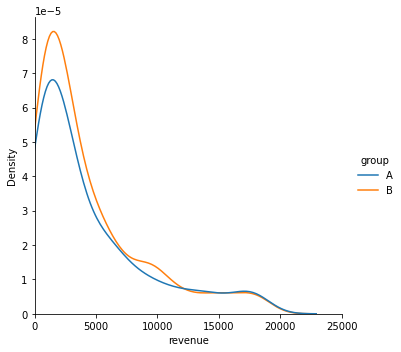

In [16]:
plt.figure(figsize=(20,8))
ax = sns.displot(data=pd.concat([orders_a, orders_b]), x="revenue", hue="group", kind="kde")

ax.set(xlim=(0, 25000));

In [17]:
orders_a['revenue'].mean(), orders_b['revenue'].mean()

(4442.257874015748, 4314.374784110535)

/Users/billybob/.pyenv/versions/3.9.11/envs/data-analysys-3.9.11/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/billybob/.pyenv/versions/3.9.11/envs/data-analysys-3.9.11/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


({'m': 120.59298100172711,
  'std': 283.09789248091187,
  'm1': 4443.914658031088,
  'm2': 4323.321677029361,
  'std1': 202.8598295505862,
  'std2': 197.69838109319318,
  'Kv1': 0.0456489030868259,
  'Kv2': 0.04572835330380403,
  'pvalue': 0.6701251459701286},
 <AxesSubplot:ylabel='Density'>,
 <AxesSubplot:ylabel='Density'>)

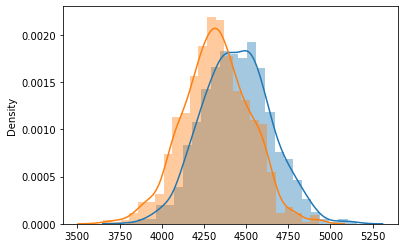

In [18]:
bootstrap(a=orders_a['revenue'], b=orders_b['revenue'], iter_count=1000)

Похоже, что на основную массу заказов рекламное предложение не действует — никакой стат. значимой разницы между группами нет.
</br>
Однако, если учитывать выбросы, то средний чек оказывается выше на 26%. Это может быть просто случайностью, но может объясняться и тем, что рекомендации могли  сильно увеличить корзины людей, которые готовы были потратить очень много.

Можем посмотреть, есть ли среди выбросов какие-то заметные изменения или это просто случайность:

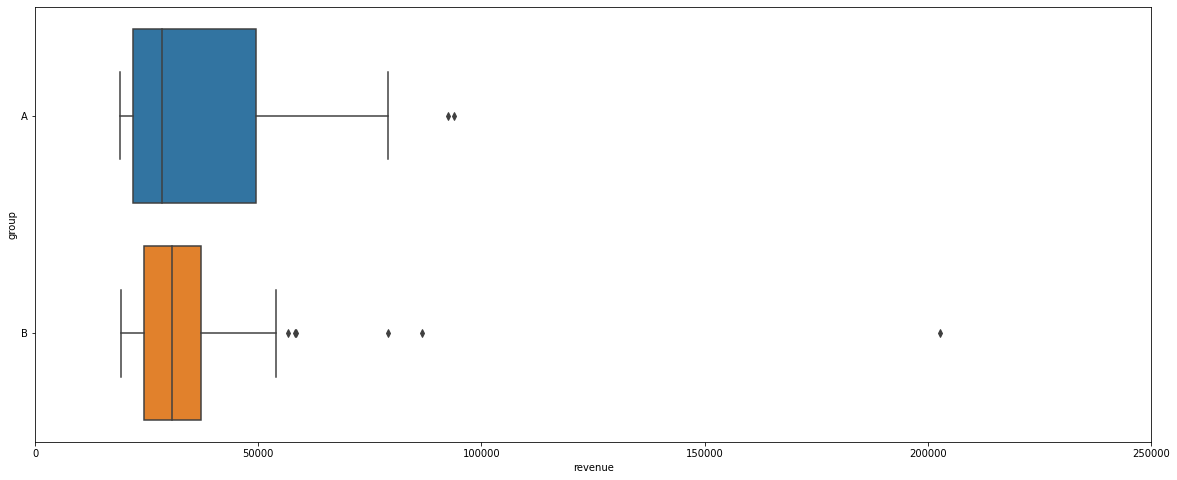

In [19]:
outliers = orders[
    ((orders['group'] == 'A') & (orders['revenue'] > a_high_ci)) \
    | ((orders['group'] == 'B') & (orders['revenue'] > b_high_ci))
]


plt.figure(figsize=(20,8))
ax = sns.boxplot(data=outliers, x='revenue', y='group')

ax.set(xlim=(0, 250000))
plt.show();

In [20]:
outliers[outliers['group'] == 'B'].sort_values(by='revenue', ascending=False).head(10)

,transactionId,visitorId,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B
744,3668308183,888512513,2019-08-27,86620,B
682,1216533772,4266935830,2019-08-29,78990,B
940,2420050534,4003628586,2019-08-08,58550,B
873,2519737434,4256040402,2019-08-08,58220,B
60,1421016313,4256040402,2019-08-16,56650,B
613,4071177889,3931967268,2019-08-07,53904,B
1142,3815014015,2606908679,2019-08-13,52900,B
755,1234615529,2279926127,2019-08-30,45780,B


In [21]:
outliers[outliers['group'] == 'A'].sort_values(by='revenue', ascending=False).head(10)

,transactionId,visitorId,date,revenue,group
858,192721366,1316129916,2019-08-27,93940,A
1136,666610489,1307669133,2019-08-13,92550,A
662,1811671147,4266935830,2019-08-29,78990,A
743,3603576309,4133034833,2019-08-09,67990,A
1103,1348774318,1164614297,2019-08-12,66350,A
1099,316924019,148427295,2019-08-12,65710,A
949,1347999392,887908475,2019-08-21,60450,A
1029,469609643,2378935119,2019-08-10,58220,A
131,3163614039,2254586615,2019-08-22,53904,A
287,587872075,2254456485,2019-08-24,53904,A


Даже выбросы не различаются между группами, кроме аномально большого заказа почти на 1,3 млн в группе B. Именно этот заказ и ещё один заказ на 202 тыс так сильно увеличивают средний чек группы B.

**Вывод:**
</br>
Какой-либо значимой разницы в среднем чеке между группами нет.

#### ARPPU

Для начала нужно сагрегировать данные по покупателям:

In [22]:
orders_by_customers = \
    orders \
    .groupby(['visitorId', 'group']) \
    .agg(
        dates = ('date', pd.Series.nunique),
        orders = ('transactionId', pd.Series.count),
        revenue = ('revenue', pd.Series.sum)
    ) \
    .reset_index()

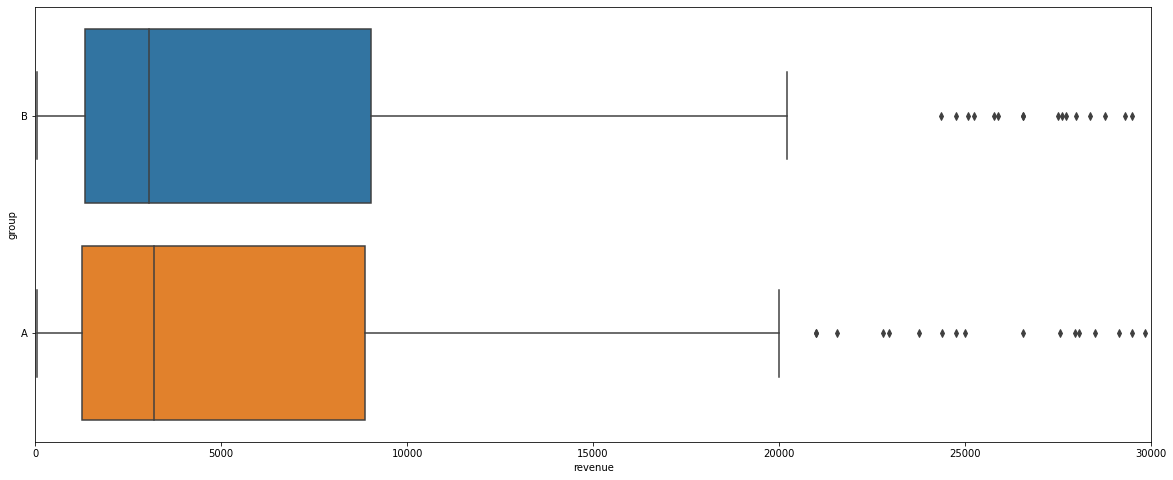

In [23]:
plt.figure(figsize=(20,8))
ax = sns.boxplot(data=orders_by_customers, x='revenue', y='group')

ax.set(xlim=(0, 30000));

Похоже, здесь такая же ситуация, что и с AOV.

In [24]:
orders_a = orders_by_customers[(orders_by_customers['group'] == 'A')].copy()
a_high_ci = orders_a['revenue'].quantile(.75) + 1.5 * (orders_a['revenue'].quantile(.75) - orders_a['revenue'].quantile(.25))
a_low_ci = orders_a['revenue'].quantile(.75) - 1.5 * (orders_a['revenue'].quantile(.75) - orders_a['revenue'].quantile(.25))
orders_a = orders_a[(orders_a['revenue'] <= a_high_ci) & (orders_a['revenue'] >= a_low_ci)]

orders_b = orders_by_customers[(orders_by_customers['group'] == 'B')].copy()
b_high_ci = orders_b['revenue'].quantile(.75) + 1.5 * (orders_b['revenue'].quantile(.75) - orders_b['revenue'].quantile(.25))
b_low_ci = orders_b['revenue'].quantile(.75) - 1.5 * (orders_b['revenue'].quantile(.75) - orders_b['revenue'].quantile(.25))
orders_b = orders_b[(orders_b['revenue'] <= b_high_ci) & (orders_b['revenue'] >= b_low_ci)]

In [25]:
orders_a['revenue'].mean(), orders_b['revenue'].mean()

(4757.257641921397, 4774.310986964619)

/Users/billybob/.pyenv/versions/3.9.11/envs/data-analysys-3.9.11/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/billybob/.pyenv/versions/3.9.11/envs/data-analysys-3.9.11/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


({'m': -21.668476722532574,
  'std': 307.10581504418377,
  'm1': 4750.932158286778,
  'm2': 4772.600635009311,
  'std1': 215.41488850078434,
  'std2': 220.872707199337,
  'Kv1': 0.045341604831180035,
  'Kv2': 0.04627931898997161,
  'pvalue': 0.9437503037037633},
 <AxesSubplot:ylabel='Density'>,
 <AxesSubplot:ylabel='Density'>)

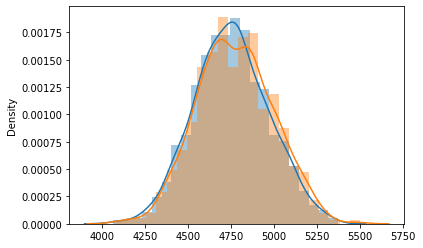

In [26]:
bootstrap(a=orders_a['revenue'], b=orders_b['revenue'], iter_count=1000)

**Вывод:**
</br>
По ARPPU между группами практически нет различий.